# Приоритизация гиотез и А/В тестирование и для интернет-магазина.

## Описание проекта

Необходимо приоритизировать гипотезы для увеличения выручки крупного интернет-магазина, запустить A/B-тест и проанализировать его результаты. 

## Цель проекта

Определение возможных путей повышения выручки интернет-магазина на основании приоретизации гипотез и A/B-тестирования

## План работы
1. Подготовка и очистка данных
2. Приоретизация гипотез по фреймворкам ICE и RICE
3. Анализ A/B-теста:
-  Подготовка к проведению анализа,
- анализ кумулятивного среднего чека по группам и количества заказов по пользователям
- расчет перцентилей количества заказов на пользователя и их стоимости, 
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным,
- расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.
- Вывод по результатам А/В теста


### Импорт библиотек:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import scipy.stats as stats
from collections import defaultdict

### Загрузка, описание и подготовка данных

In [2]:
try:
    hyp = pd.read_csv('/Users/a/Downloads/hypothesis.csv')
    orders = pd.read_csv('/Users/a/Downloads/orders.csv')
    visitors = pd.read_csv('/Users/a/Downloads/visitors.csv')

except:
    hyp = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hyp.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Описание данных:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Описание данных:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Проверка на дубликаты:

In [5]:
orders[orders.duplicated()]

,transactionId,visitorId,date,revenue,group


In [6]:
orders[orders.duplicated(['transactionId'])]

,transactionId,visitorId,date,revenue,group


Полных дубликатов не обнаружено, проверим возможность "подглядывания", т.е. проверим, есть ли пользователи, попали в обе группы одновременно

In [7]:
# выделим клиентов, попавших более чем в одну группу
double_clients = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId']

# отфильтруем, удалив клиентов, попавших более чем в одну группу, из таблицы orders
orders_new = orders.query('visitorId not in @double_clients')
# таблицу visitors оставляем без изменений

Обработка закончена. Датафрейм orders почищен от заранее некорректных данных.

In [8]:
# для гарантии отформатируем тип данных в 'date', проверим начальную и конечную дату в наборе данных
orders_new['date'] = orders_new['date'].astype('datetime64[D]')
orders_new['date'] = orders_new['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))

print('\nНачальная дата {}, конечная дата {}\n'.format(orders_new['date'].min(), orders_new['date'].max()))

orders_new['date'] = orders_new['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders_new.info()


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


/tmp/ipykernel_130/198434008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_new['date'] = orders_new['date'].astype('datetime64[D]')
/tmp/ipykernel_130/198434008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_new['date'] = orders_new['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
/tmp/ipykernel_130/198434008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Описание данных:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [10]:
# для гарантии оторматируем тип данных в 'date', проверим начальную и конечную дату в наборе данных
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))

print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()


Начальная дата 2019-08-01, конечная дата 2019-08-31

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Вывод по выгрузке и подготовке данных:**
Данные прочитали, изменили тип данных у столбцов с датами

### Приоритизация гипотез.

Применим фреймворк ICE и RICE для приоритизации гипотез. Отсортируем по убыванию приоритета.

Как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло

In [11]:
hyp['ICE'] = hyp['Impact'] * hyp['Confidence'] / hyp['Efforts']
hyp['RICE'] = hyp['Reach'] * hyp['Impact'] * hyp['Confidence'] / hyp['Efforts']

In [12]:
pd.options.display.max_colwidth = 120
hyp.sort_values(by='ICE', ascending=False)[['Hypothesis', 'ICE', 'RICE']]

,Hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


In [13]:
pd.options.display.max_colwidth = 120
hyp.sort_values(by='RICE', ascending=False)[['Hypothesis', 'ICE', 'RICE']]

,Hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


- **По фреймворку ICE наибольшую оценку имели гпиотезы 8,0 и 7.**
- **По RICE приоритетные гиgотезы 7,2 и 0.**

Это объясняется тем, что в случае фреймворка ICE в отличие от RICE мы не учитывали охват изменений и 7 гипотеза имеет высокий показатель Reach, она затронет очень многих пользователей.

### Анализ A/B-теста

#### Подготовка к проведению анализа

Проверим наличие разницы в размере групп в выборке, а также корректно ли был рассчитан размер выборки для проведения теста.

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 468
Кол-во покупок в группе B: 548


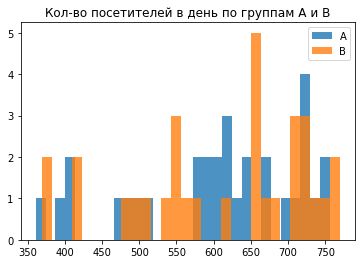

P-value:0.7301376549390499
Разница в количестве посетителей в группах A и B статистически не значима

Начальная конверсия: 0.025
Полученная после изменений конверсия: 0.029
Относительное изменение конверсии после изменений: 0.138

Вводим начальную конверсию и полученное относительное изменение конверсии в калькулятор
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35855 для корректного проведения тестирования
В нашем случае количество 37652 посещений
Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницы
в количестве посещений м/у группами не обнаружено.


In [14]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders_new[orders_new['group']=='A'])
purchasesB = len(orders_new[orders_new['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))

plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)

plt.legend()
plt.title('Кол-во посетителей в день по группам A и B')
plt.show()


results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05

print('P-value:{}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически не значима\n')
    
initial_conversion = len(orders_new[orders_new['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders_new[orders_new['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()

print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))

print('\nВводим начальную конверсию и полученное относительное изменение конверсии в калькулятор\n'
     'Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html\n'
     'Получаем необходимое количество выборки 35855 для корректного проведения тестирования\n'
     'В нашем случае количество {} посещений\n'
      'Кол-во выборки для A/B тестирования корректно подобрано, ' 
      'статистически значимой разницы\nв количестве посещений м/у группами не обнаружено.'.format(visitors['visitors'].sum()))

#### Построим график кумулятивной выручки по группам.

Для этого:

In [15]:
# Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders
datesGroups = orders_new[['date', 'group']].drop_duplicates()

Далее объявим переменную ordersAggregated, содержащую:
- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

А также visitorsAggregated, содержащую:
- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [16]:
ordersAggregated = datesGroups.apply\
(lambda x: orders_new[np.logical_and(orders_new['date']<= x['date'], orders_new['group'] == x['group'])]\
 .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])


visitorsAggregated = datesGroups.apply\
(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
 .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group']) 

In [17]:
# Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated
# по колонкам 'date', 'group' методом merge()

ordersAggregated['date'] = ordersAggregated['date'].astype('datetime64[D]')
visitorsAggregated['date'] = visitorsAggregated['date'].astype('datetime64[D]')

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


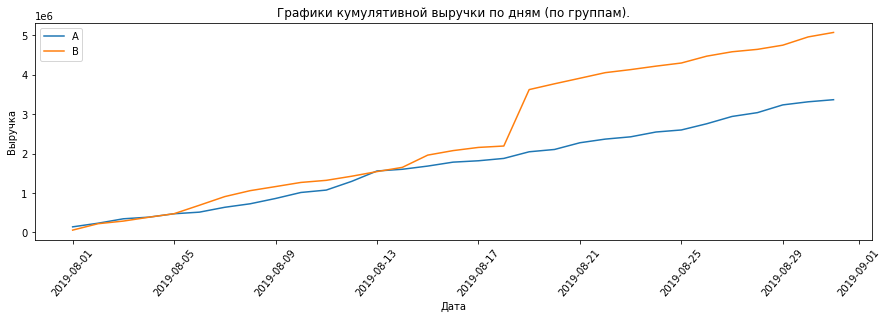

In [18]:
# Объявим переменные cumulativeRevenueA и cumulativeRevenueB,
# в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

fig = plt.figure(figsize=(15, 4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=50)
plt.legend() 
plt.title('Графики кумулятивной выручки по дням (по группам).')
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.show()

Группа В стабильно приносит большую выручку, чем группа А

Во второй половине теста вероятно был сделан заказ на особо крупную сумму, что вывело показатель кумулятивной выручки по группе В сильно вперед.

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА: постаралась исправить, вероятно аномально крупный заказ </b>
</div>

#### Построим график кумулятивного среднего чека по группам.

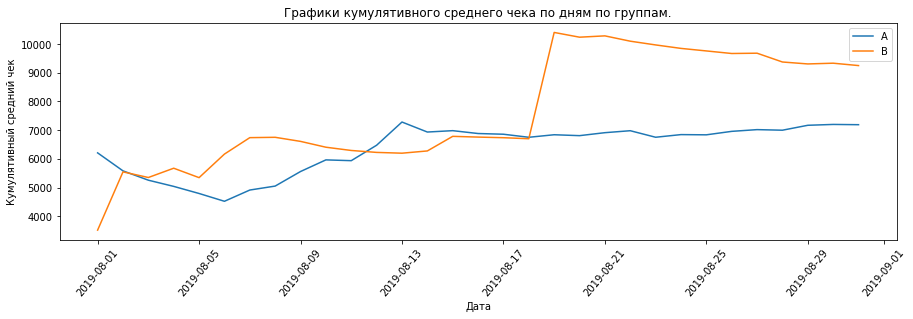

In [19]:
fig = plt.figure(figsize=(15, 4))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')


plt.xticks(rotation=50)
plt.legend() 
plt.title('Графики кумулятивного среднего чека по дням по группам.')
plt.xlabel("Дата")
plt.ylabel("Кумулятивный средний чек")
plt.show()

Кумулятивное значение по сегментам колеблется. Принмать решение по этой метрике рано, необходимо иссследовать на выбросы, так как **особенно заметен резкий скачок по среднему чеку в группе В в середине эксперимента.**

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

In [20]:
# Объединим таблицы cumulativeRevenueA и cumulativeRevenueB

mergedCumulativeRevenue = cumulativeRevenueA\
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

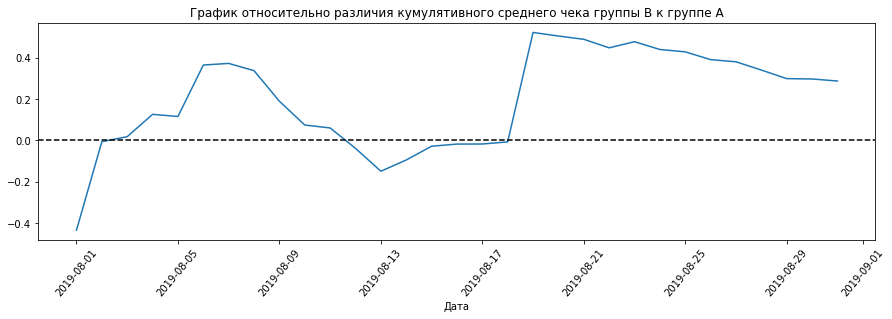

In [21]:
# Построим график относительно различия кумулятивного среднего чека группы B к группе A. 
fig = plt.figure(figsize=(15, 4))


(
    plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']
                                               /mergedCumulativeRevenue['ordersB'])
             /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
)
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=50)
plt.title('График относительно различия кумулятивного среднего чека группы B к группе A')
plt.xlabel("Дата")
plt.show()

Как и описывалось выше результаты теста имеют знаительные колебания в течение эксперимента. Вероятно это указывает на даты, в которые были сделаны аномально большие заказы.

#### График среднего количества заказов по группам.

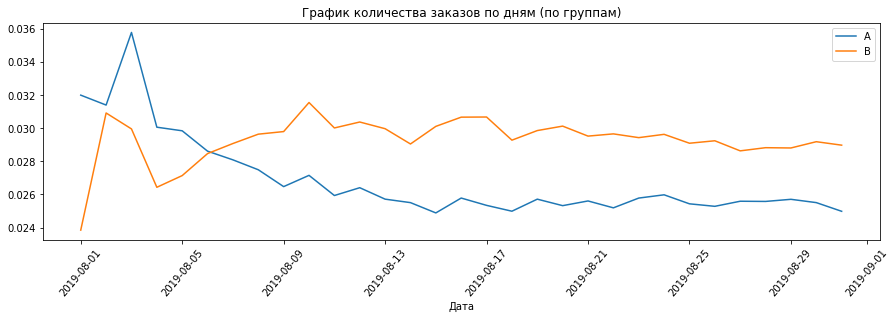

In [22]:
# считаем среднее количество заказов на пользователя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
fig = plt.figure(figsize=(15, 4))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xticks(rotation=50)
plt.legend()
plt.title('График количества заказов по дням (по группам)')
plt.xlabel("Дата")
plt.show()

В группе В стабильно более высокое количество заказов

#### График относительного изменения количества заказов группы B к группе A. 

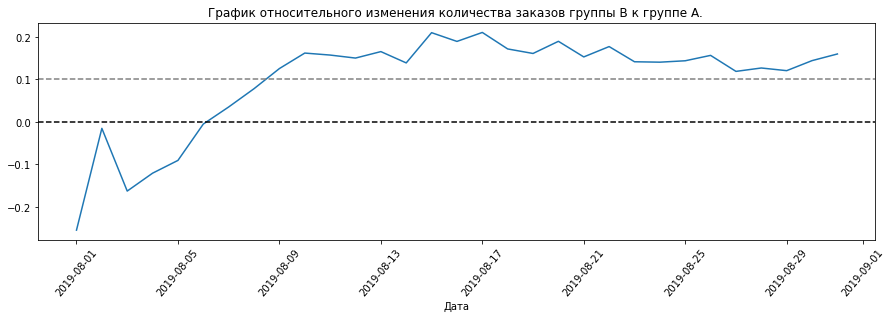

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=(15, 4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xticks(rotation=50)
plt.title('График относительного изменения количества заказов группы B к группе A. ')
plt.xlabel("Дата")
plt.show()



Относительное изменение количества заказов в группе B стабильно значительно выше чем в группе A (на 10% по просшествии 1 недели после начала теста)

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [24]:
# Найдем число заказов по пользователям — создадим отдельный датафрейм 
ordersByUsers = (
    orders_new.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'transactionId']

ordersByUsers.sort_values(by='transactionId', ascending=False).head(5)

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


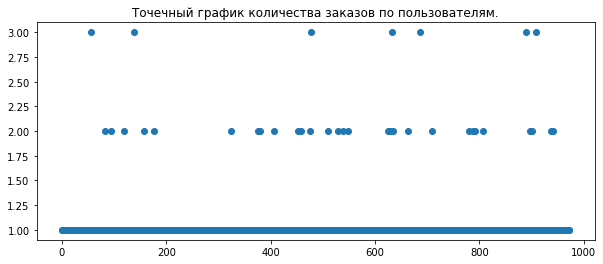

In [25]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(10,4))
plt.scatter(x_values, ordersByUsers['transactionId'])
plt.title('Точечный график количества заказов по пользователям.')
plt.show()

Подавляющее большинство пользователей не совершает более 2 заказов

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.


In [26]:
percentiles = np.percentile(ordersByUsers['transactionId'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 1.0
99: 2.0


Больше 2 заказов совершают только 5% пользователей

#### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

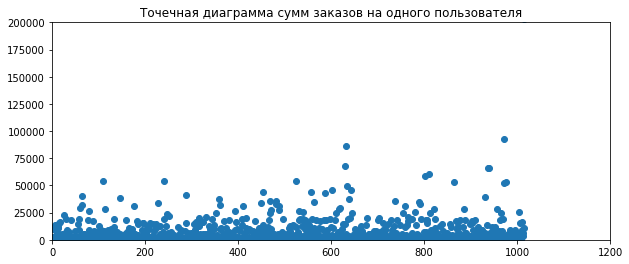

In [27]:
x_values = pd.Series(range(0, len(orders_new)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders_new['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()

Судя по графикам, большая часть пользователей делает покупки суммой не больше 25-30 т.р. Проверим это далее.

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [28]:
percentiles = np.percentile(orders_new['revenue'], [95, 99])
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 26785
99: 53904


Только 5% заказов дороже 26785 руб.

#### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

##### Подготовка данных.

Отобразим в датафрейме data:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [29]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders_new[orders_new['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders_new[orders_new['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


##### Посчитаем статистическую значимость различия в среднем количестве заказов между группами по "сырым" данным

Выполним проверку нулевой и альтернативной гипотез:
   - Нулевая гипотеза: статистически значимых различий в среднем количестве заказов между группами нет
   - Альтернативная гипотеза: статистически значимые различия в среднем числе заказов между группами есть.
   
**Применим статистический критерий Манна-Уитни к полученным выборкам, определим уровень статистической значимости как 0.05**

In [30]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'].
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

ordersByUsersA = (
    orders_new[orders_new['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders_new[orders_new['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим критерий и отформатируем p-value, округлив его до 4 знаков после запятой.
# Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1. 

alpha = 0.05 

results = stats.mannwhitneyu(sampleA, sampleB)

print('P-value: {:.4f}'.format(results.pvalue))

print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.4f}'.format(sampleB.mean()/sampleA.mean()-1))

if results.pvalue < alpha:
    print('По неочищенным данным в конверсии групп A и B разница статистически значима')
else:
    print('По неочищенным данным различий в конверсии групп A и B нет')


P-value: 0.0110

Относительный прирост конверсии группы B по отношению к группе A: 0.1598
По неочищенным данным в конверсии групп A и B разница статистически значима


Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
**По неочищенным данным в среднем числе заказов между группами имеются значитиельные статистически значимые различия.**

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Выполним проверку нулевой и альтернативной гипотез:
   - Нулевая гипотеза: статистически значимых различий в среднем чеке заказа между группами нет
   - Альтернативная гипотеза: статистически значимые различия в среднем чеке заказа между группами есть.

In [31]:
# передадим критерию mannwhitneyu() данные о выручке с заказов. 
# а также найдём относительные различия в среднем чеке между группами:

results = stats.mannwhitneyu(orders_new[orders_new['group']=='A']['revenue'], orders_new[orders_new['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))

print('Относительное изменение среднего чека в группе B по отношению к группе A: {0:.3f}'.format(orders_new[orders_new['group']=='B']['revenue']\
                       .mean()/orders_new[orders_new['group']=='A']['revenue'].mean()-1))

if results.pvalue < alpha:
    print('По неочищенным данным разница в средних чеках по группам A и B статистически значима')
else:
    print('По неочищенным данным различий в средних чеках по группам A и B нет')

P-value: 0.8294908998149533
Относительное изменение среднего чека в группе B по отношению к группе A: 0.287
По неочищенным данным различий в средних чеках по группам A и B нет


Нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, подтверждаем.
**По неочищенным данным в среднем чеке заказа между группами статистически значимых различий нет.**

#### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

- Ранее мы выяснили, что подавляющее большинство пользователей не делает более 2 заказов и сумма 1 покупки в большинстве случаев не превышает 26785 руб. 

- Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 26785 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 
- Узнаем, сколько всего аномальных пользователей.

In [32]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество "аномальных" пользователей', abnormalUsers.shape[0]) 

Количество "аномальных" пользователей 70


Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

In [33]:
# подготовим выборки количества заказов по пользователям по группам теста:

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

# Применим статистический критерий Манна-Уитни к полученным выборкам:

results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {}'.format(results.pvalue))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

if results.pvalue < alpha:
    print('По очищенным данным в конверсии групп A и B разница статистически значима')
else:
    print('По очищенным данным различий в конверсии групп A и B нет')

P-value: 0.01235203801772639
0.182
По очищенным данным в конверсии групп A и B разница статистически значима


#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [34]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.956
-0.021


**По очищенным данным различий в средних чеках в группах A и B нет**

### Вывод по результатам А/В теста

Остановить тест, зафиксировать победу группы В.

Пояснение к выводу:

1. Выборка данных имеет корректный размер.
2. Кумулятивные метрики по выручке, среднему чеку и конверсии почти все время лидировали в группе B. 
3. После очистки разница между средними чеками между группами стала минимальна и так как до и после очистки данных показатель количества заказов в группе B составлял больше показателя в группе A - до очистки данных на 13,3% и после очистки на 14.9%, то

данная **разница в количестве заказов между группами и до и после очистки данных является статистически значимой, что пользволяет нам сделать вывод о том, что мы можем A/B тест и зафиксировать победу группы B.**

**Большее количество заказов обеспечит рост выручки**

**Рекомендации:**
- Отладить алгоритм показа одной и той же версии сайта для пользоваталей в зависимости от присвоенной им при первом посещении сайта группы на все время проведения А/В теста.
- На основании результатов проведенного А/В теста рекомендуется внести изменения в форму сайта, на ту, которая демонстрировалась группе В, так как согласно результатам исследования это может увеличить количество заказов.


**Также отметим, что при приоритезации гипотез среди тех, которые охватывают меньшее количество пользователей наиболее перспективными являются следующие (в порядке убывания приоритета):**
- Запустить акцию, дающую скидку на товар в день рождения	
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

**Среди гипотез, имеющий больший охват пользователей являются, наиболее перспективные (в порядке убывания приоритета):**
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	